In [1]:
from code_file.imports_and_libraries import *
from code_file.dataset_creation import *
from code_file.positional_encodings import *
from code_file.models import *
from code_file.train_and_test import *
from code_file.visualizations import *

In [2]:
def make_double_sine_dataset(N: int=cfg.num_of_samples, t_interval: list=cfg.time_interval, t_k: int=cfg.discr_of_time, w_min: float=cfg.omega_min, w_max: float=cfg.omega_max, 
                      seed=cfg.seed, mu: float=cfg.mu, sigma: float=cfg.noise_std, noise: bool=False):
    '''
    Generate a dataset with N samples of sine waves y=sin(wi*t) + sin(wj*t) with frequencies w sampled uniformly from [w_min, w_max] - both limit values are included.
    Optionally, Gaussian noise N(mu, sigma) can be added to each sample.

    Returns: tuple of NumPy arrays (V, target, t_val)
    '''

    rng = np.random.default_rng(seed)

    #evenly space time in t_k levels
    t_val = np.linspace(t_interval[0], t_interval[1], t_k)
    #generate N frequencies from [w_min ,w_max] for two mix omegas
    w_val = rng.uniform(w_min, w_max, size=(N,2))
    
    V, target = [], []

    #generate N samples of sin(wi*t) + sin(wj*t)
    for w1, w2 in w_val:
        if noise:
            Vi = 1 * np.sin(w1 * t_val) + 1 * np.sin(w2 * t_val) + rng.normal(mu, sigma, size=t_k)
        else:
            Vi = 1 * np.sin(w1 * t_val) + 1 * np.sin(w2 * t_val)
        V.append(np.array(Vi))
        
        target.append(np.sort([w1,w2]))
        #target.append(np.array([w1,w2]))
        
    #return tuple of arrays of 
    return np.array(V), np.array(target), t_val

In [3]:
class HeadHybridFlow(nn.Module):
    '''Normalizing flow head for omegas - now mixture of 2.'''

    def __init__(self, context_dim: int, hidden_features: int=cfg.flow_hidden_features, num_layers: int=cfg.flow_num_layers, out_dim: int=2):
        super().__init__()

        self.context_dim  = context_dim
        self.hidden_features = hidden_features
        self.num_layers = num_layers
        self.out_dim = out_dim
        self.context_net = nn.Linear(context_dim, hidden_features)

        #MAF - creating matrixes which will transform distribution
        transform_list = []
        for _ in range(num_layers):
            transform_list.append(transforms.MaskedAffineAutoregressiveTransform(features=out_dim, hidden_features=hidden_features, context_features=hidden_features))

        #chaining transformation sequence
        transform = transforms.CompositeTransform(transform_list)

        #wraps flow as object and keeps the information
        base_dist = distributions.StandardNormal(shape=[out_dim])
        self.flow = flows.Flow(transform=transform, distribution=base_dist)

    def encode_context_head(self, context):
        return self.context_net(context)

    def log_prob(self, omega, context):

        ctx = self.encode_context_head(context)
        log_p = self.flow.log_prob(inputs=omega, context=ctx)
        return log_p

    def sample(self, context, num_samples: int):
        ctx = self.encode_context_head(context)  
    
        samples_bs1 = self.flow.sample(num_samples=num_samples, context=ctx)
        if samples_bs1.dim() == 3:
            S0, S1, D = samples_bs1.shape

            if S0 == num_samples:
                # shape (S, B, D) -> want (B, S, D)
                samples = samples_bs1.permute(1, 0, 2).contiguous()
            elif S1 == num_samples:
                # shape (B, S, D) -> already good
                samples = samples_bs1


        return samples



class TransformerModel3(nn.Module):
    '''Normalizing-flow head - Hybrid-flow solution.
        - forward(x) returns the mean of samples
        - log_prob(x, y) for training with NLL
        - sample(x, S) for uncertainty (S samples)'''

    def __init__(self, seq_len: int=cfg.discr_of_time, d_model: int=cfg.dmodel, nhead: int=cfg.nhead, num_layers: int=cfg.num_layers,
                 dim_f: int=cfg.dim_f, dropout: float=cfg.dropout, flow_hidden_features: int=cfg.flow_hidden_features, flow_num_layers: int=cfg.flow_num_layers,
                 out_dim: int=2):

        super().__init__()

        self.input_embedding = nn.Linear(1, d_model)
        self.position_encoding = PositionalEncoding(d_model, seq_len)

        layer = nn.TransformerEncoderLayer(d_model, nhead, dim_f, dropout=dropout, batch_first=True)        #creates layers/blocks
        self.transformer_encoder = nn.TransformerEncoder(layer, num_layers)

        self.pre_head_norm = nn.LayerNorm(d_model)

        #flowhead
        self.flow_head = HeadHybridFlow(context_dim=d_model, hidden_features=flow_hidden_features, num_layers=flow_num_layers, out_dim=out_dim)
        #self.reg_head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, d_model),  nn.ReLU(), nn.Linear(d_model, out_dim))

    def forward(self, src, num_samples: int = 20):
        '''Forward pass'''
        src = src.unsqueeze(-1)
        src = self.input_embedding(src)
        src = self.position_encoding(src)
        z = self.transformer_encoder(src)
        pool = z.mean(dim=1)
        head_norm = self.pre_head_norm(pool)

        samples = self.flow_head.sample(head_norm, num_samples)
        samples_sorted, _ = torch.sort(samples, dim=-1)
        mu = samples_sorted.mean(dim=1)
        return mu

    def log_prob(self, src, target):
        src = src.unsqueeze(-1)
        src = self.input_embedding(src)
        src = self.position_encoding(src)
        z = self.transformer_encoder(src)

        pool = z.mean(dim=1)
        head_norm = self.pre_head_norm(pool)

        #(w1, w2) and (w2, w1) and their mixture
        log_p1 = self.flow_head.log_prob(target, context=head_norm)
        log_p2 = self.flow_head.log_prob(target.flip(dims=[1]), context=head_norm)

        #p_sym = 0.5 * (p(w1,w2) + p(w2,w1))
        stacked = torch.stack([log_p1, log_p2], dim=1)
        log_p_sym = torch.logsumexp(stacked, dim=1) - math.log(2.0)

        return log_p_sym

    def sample(self, src, num_samples: int = 100):
        src = src.unsqueeze(-1)
        src = self.input_embedding(src)
        src = self.position_encoding(src)
        z = self.transformer_encoder(src)
        pool = z.mean(dim=1)
        head_norm = self.pre_head_norm(pool) 
        
        samples = self.flow_head.sample(head_norm, num_samples)
        return samples

In [4]:
@torch.no_grad()
def evaluate_hybrid(loader, model, device):
    """Evaluation for 2D frequency targets that are unordered sets {w1, w2}."""

    model.eval()
    mse_sum, mae_sum, n = 0.0, 0.0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)

        se = (pred - yb).pow(2)
        ae = (pred - yb).abs()

        mse_sum += se.sum().item()
        mae_sum += ae.sum().item()
        n += yb.numel()

    mse = mse_sum / n
    mae = mae_sum / n
    return mse, mae

@torch.no_grad()
def prediction_collecter_plot_twofreq_perm(loader, model, device):
    """
    Collect y_true, y_pred for 2D unordered targets {w1, w2},
    aligned per sample using the better of the two permutations.
    """
    model.eval()
    y_true_list, y_pred_list = [], []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)

        y_true_list.append(aligned_true.cpu())
        y_pred_list.append(aligned_pred.cpu())

    y_true = torch.cat(y_true_list, dim=0)
    y_pred = torch.cat(y_pred_list, dim=0)
    return y_true, y_pred

def mse_ordered(pred, target):
    return (pred - target).pow(2).mean()

def train_and_eval_training_flow2(train_loader, val_loader, device, model, optimizer, scheduler, 
                            max_epochs: int=cfg.epochs, print_update: bool=False, lambda_reg: float = 1):
    '''Train the model and evaluate on validation. Saves best model based on validation MSE through training but with NLL loss function'''

    #real loop and training and everything....
    best_val = float("inf")
    best_state = None

    train_mse_hist, val_mse_hist = [], []

    for epoch in range(1, max_epochs + 1):
        model.train()
        
        #training step
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            #symmetric NLL
            log_p = model.log_prob(xb, yb)
            loss_nll = -log_p.mean()

            #with torch.no_grad():
            pred_mu = model(xb)                   # (B,2) posterior mean of (w_low,w_high)
            loss_reg = perm_invariant_mse(pred_mu, yb)

            loss = loss_nll + lambda_reg * loss_reg

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        scheduler.step()

        tr_mse, tr_mae = evaluate_hybrid(train_loader, model, device)
        val_mse, val_mae = evaluate_hybrid(val_loader, model, device)

        train_mse_hist.append(tr_mse)
        val_mse_hist.append(val_mse)

        #validation steo
        if val_mse < best_val:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if print_update:
            if epoch % 10 == 0:
                tr_mse, tr_mae = evaluate(train_loader, model, device)
                print(f"Epoch {epoch:3d}; Train MSE {tr_mse:.6f}, MAE {tr_mae:.6f}; Val MSE {val_mse:.6f}, MAE {val_mae:.6f}")

    #load the best weights
    model.load_state_dict(best_state)

    return model, train_mse_hist, val_mse_hist




In [5]:
#setup for reproducibility and device
set_seed()
device = set_device()

#setup for model and more
model = TransformerModel3(out_dim=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)

#creating dataset and converting to tensor dataset
#V_np, tar_np, t_np = make_sine_dataset(noise=True)
V_np, tar_np, t_np = make_double_sine_dataset(noise=True)
ds_full = from_array_to_tensor_dataset(V_np, tar_np)

#splitting to train, val and test parts
train_loader, val_loader, test_loader = split_and_load(ds_full)

#training and validation steps
model, train_mse_hist, val_mse_hist = train_and_eval_training_flow2(train_loader, val_loader, device, model, optimizer, scheduler, lambda_reg=5)

#test step
test_mse, test_mae = evaluate_hybrid(test_loader, model, device)
print(f"Test MSE {test_mse:.6f}, MAE {test_mae:.6f}")

Test MSE 0.888685, MAE 0.544683


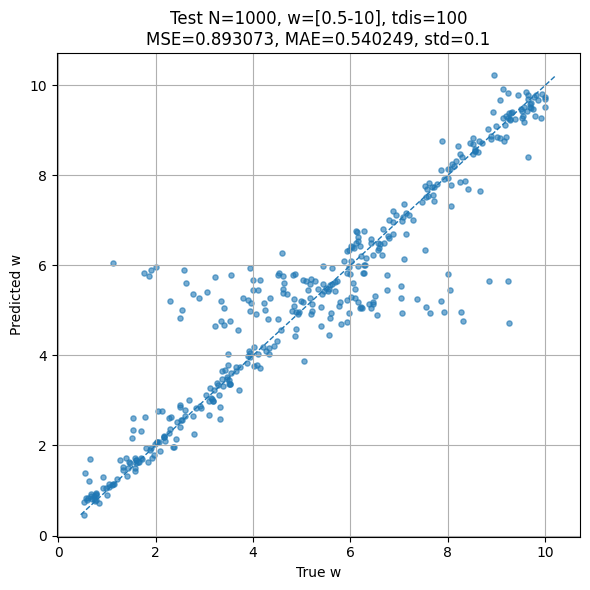

In [37]:
y_true, y_pred = prediction_collecter_plot(test_loader, model, device)

    #plots - save or show option
plot_pred_vs_true(y_true, y_pred, test_mse, test_mae, save_plot=False, show_plot=True)

In [7]:
#plotting data collection
y_true, y_pred = prediction_collecter_plot_twofreq_perm(test_loader, model, device)

#plots - save or show option
plot_pred_vs_true(y_true, y_pred, test_mse, test_mae, save_plot=False, show_plot=True)
plot_loss_curves(train_mse_hist, val_mse_hist, save_plot=False, show_plot=True)
#plot_loss_curves(train_mse_hist, val_mse_hist, save_plot=False, show_plot=True, y_limit=1, zoom='0.025')
#plot_loss_curves(train_mse_hist, val_mse_hist, save_plot=False, show_plot=True, y_limit=0.025, zoom='0.025')

NameError: name 'aligned_true' is not defined

In [8]:
def plot_pred_vs_true_double(
    y_true,
    y_pred,
    test_mse,
    test_mae,
    N: int = cfg.num_of_samples,
    t_disc: int = cfg.discr_of_time,
    w_min: float = cfg.omega_min,
    w_max: float = cfg.omega_max,
    seed = cfg.seed,
    sigma: float = cfg.noise_std,
    folder = cfg.plots_dir,
    save_plot: bool = False,
    show_plot: bool = False,
):
    """
    Plot predicted vs true values for double-frequency model:
      - true w1 vs pred w1
      - true w2 vs pred w2
      - (w1, w2) true vs predicted in joint space
    """

    # --- convert to numpy safely ---
    if hasattr(y_true, "detach"):
        y_true_np = y_true.detach().cpu().numpy()
        y_pred_np = y_pred.detach().cpu().numpy()
    else:
        y_true_np = np.asarray(y_true)
        y_pred_np = np.asarray(y_pred)

    # shape checks
    assert y_true_np.shape == y_pred_np.shape, "Shapes of y_true and y_pred must match"
    assert y_true_np.shape[1] == 2, "This plotting function expects 2D targets: (N, 2)"

    w1_true = y_true_np[:, 0]
    w2_true = y_true_np[:, 1]
    w1_pred = y_pred_np[:, 0]
    w2_pred = y_pred_np[:, 1]

    # component-wise errors (just for extra info in titles)
    mae_w1 = np.mean(np.abs(w1_pred - w1_true))
    mae_w2 = np.mean(np.abs(w2_pred - w2_true))

    # --- create figure with 3 subplots ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    mn = min(y_true_np.min(), y_pred_np.min())
    mx = max(y_true_np.max(), y_pred_np.max())

    # 1) w1: true vs pred
    ax = axes[0]
    ax.scatter(w1_true, w1_pred, s=14, alpha=0.6)
    ax.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1)
    ax.set_xlabel("True w1")
    ax.set_ylabel("Predicted w1")
    ax.set_title(f"w1 – MAE={mae_w1:.4f}")
    ax.grid(True, which="both")

    # 2) w2: true vs pred
    ax = axes[1]
    ax.scatter(w2_true, w2_pred, s=14, alpha=0.6)
    ax.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1)
    ax.set_xlabel("True w2")
    ax.set_ylabel("Predicted w2")
    ax.set_title(f"w2 – MAE={mae_w2:.4f}")
    ax.grid(True, which="both")

    # 3) joint space (w1, w2)
    ax = axes[2]
    ax.scatter(w1_true, w2_true, s=14, alpha=0.4, label="true", marker="o")
    ax.scatter(w1_pred, w2_pred, s=14, alpha=0.4, label="pred", marker="x")
    ax.set_xlabel("w1")
    ax.set_ylabel("w2")
    ax.set_title("Frequency space (true vs pred)")
    ax.grid(True, which="both")
    ax.legend()

    # set consistent limits if you want to see full range clearly
    ax.set_xlim(w_min, w_max)
    ax.set_ylim(w_min, w_max)

    fig.suptitle(
        f"Double-sine – Test N={N}, w=[{w_min}-{w_max}], tdis={t_disc}\n"
        f"Overall MSE={test_mse:.6f}, MAE={test_mae:.6f}, std={sigma}",
        fontsize=10,
    )
    fig.tight_layout()

    if save_plot:
        fig.savefig(
            folder / f"T3_double_N{N}_tdis{t_disc}_w{w_min}-{w_max}_seed{seed}_std{sigma}_PREDvsREAL.png",
            dpi=300,
        )
    if show_plot:
        plt.show()

    plt.close(fig)


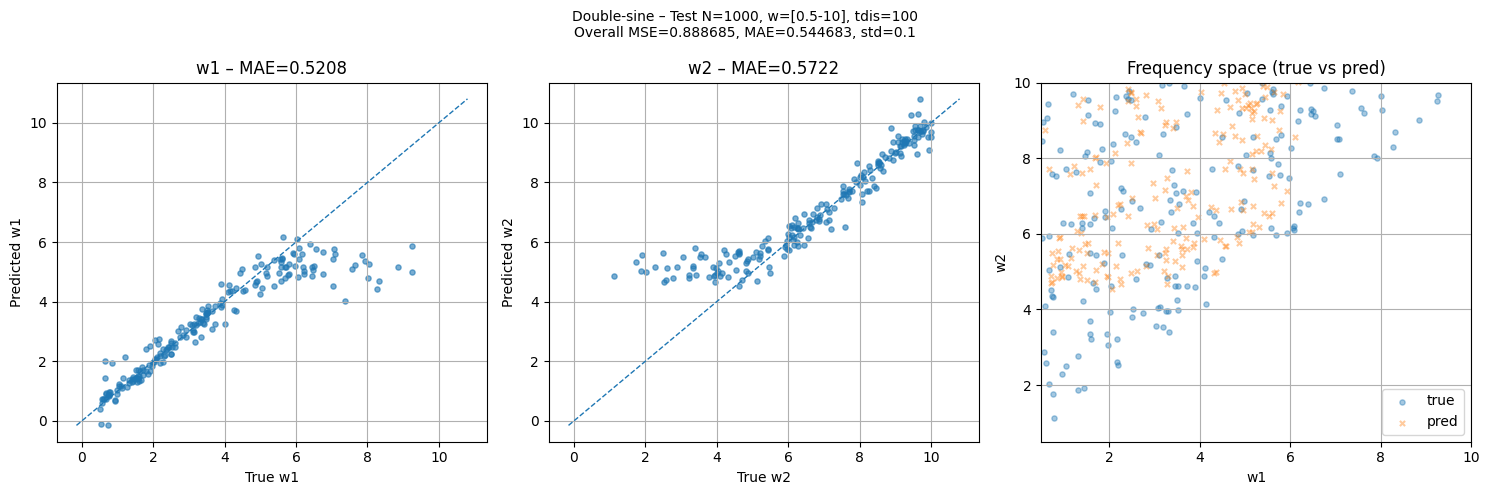

In [9]:
# collect predictions and true values from test set
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pred = model(xb)
        y_true_list.append(yb)
        y_pred_list.append(pred)

y_true_all = torch.cat(y_true_list, dim=0)
y_pred_all = torch.cat(y_pred_list, dim=0)

plot_pred_vs_true_double(
    y_true_all,
    y_pred_all,
    test_mse=test_mse,
    test_mae=test_mae,
    save_plot=True,
    show_plot=True,
)


In [22]:
@torch.no_grad()
def plot_flow_posterior_twofreq_one_example(
    model: nn.Module,
    device,
    loader,
    global_index: int = 0,
    num_samples: int = 100000,
    bins: int = 100,
    num_sigmas: int = 3,
    N: int = cfg.num_of_samples,
    t_disc: int = cfg.discr_of_time,
    w_min: float = cfg.omega_min,
    w_max: float = cfg.omega_max,
    seed=cfg.seed,
    folder=cfg.plots_dir,
    fl_hid_feat: int = cfg.flow_hidden_features,
    fl_lay: int = cfg.flow_num_layers,
    save_plot: bool = False,
    show_plot: bool = False,
):
    """
    For a chosen example (global_index), sample many times from the flow:
       (w1, w2) ~ p(w1,w2 | x)
    sort to (w_low, w_high), and plot **two** 1D posteriors side-by-side:
       p(w_low | x), p(w_high | x),
    each with true value, mean μ and ±kσ lines.
    """
    model.eval()

    # ---- find the example with global_index in the loader ----
    start = 0
    for xb, yb in loader:
        batch_size = xb.size(0)
        end = start + batch_size
        if global_index < end:
            local_idx = global_index - start

            xb = xb.to(device)
            yb = yb.to(device)

            x_one = xb[local_idx : local_idx + 1]   # (1, T)
            w_true_pair = yb[local_idx]            # (2,)
            break
        start = end
    else:
        raise IndexError(f"global_index {global_index} out of range")

    # sort the true pair into (w_low_true, w_high_true)
    w_true_np = torch.sort(w_true_pair).values.cpu().numpy()
    w_low_true, w_high_true = float(w_true_np[0]), float(w_true_np[1])

    # ---- sample from flow, sort into (w_low, w_high) ----
    samples = model.sample(x_one, num_samples=num_samples)   # (1, S, 2)
    samples = samples.squeeze(0).cpu().numpy()               # (S, 2)


    # Expected shapes:
    #   (1, S, 2)  -> choose first batch element -> (S, 2)
    #   (S, 2)     -> already fine
    if samples.ndim == 3:
        # assume (B, S, D) with B=1
        samples = samples[0]            # (S, D)
    elif samples.ndim != 2:
        raise ValueError(f"Unexpected samples shape {samples.shape}, expected (S,2) or (1,S,2)")

    if samples.shape[1] != 2:
        raise ValueError(
            f"Expected last dimension 2 (two omegas), got shape {samples.shape}. "
            "Are you sure you're using the 2-ω model here?"
        )


    samples_sorted = np.sort(samples, axis=1)  # (S, 2)
    samples_low  = samples_sorted[:, 0]
    samples_high = samples_sorted[:, 1]

    # helper function: plot 1D posterior on given axis
    def _plot_1d(ax, samples_1d, w_true, name):
        mu = samples_1d.mean()
        sigma = samples_1d.std()

        ax.minorticks_on()
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)

        ax.hist(samples_1d, bins=bins, density=True, color="tab:blue", alpha=0.8,
                label=f"flow samples {name} | x")
        ax.axvline(w_true, color="tab:orange", linestyle="--", linewidth=2,
                   label=f"true {name} = {w_true:.3f}")
        ax.axvline(mu, color="tab:red", linestyle="-", linewidth=2,
                   label=f"mean μ = {mu:.3f}")

        # ±kσ lines
        sigma_label_added = False
        ks = range(1, num_sigmas + 1)
        for k in ks:
            left  = mu - k * sigma
            right = mu + k * sigma
            label_sigma = r"±kσ lines" if not sigma_label_added else None
            sigma_label_added = True
            ax.axvline(left,  linestyle="-.", linewidth=1.8, color="tab:brown",
                       alpha=0.7, label=label_sigma)
            ax.axvline(right, linestyle="-.", linewidth=1.8, color="tab:brown",
                       alpha=0.7)

        # x-limits: a few sigmas around μ, but clipped to [w_min, w_max]
        span = max(8 * sigma, 0.02)  # avoid degenerate case
        ax.set_xlim(max(mu - span, w_min), min(mu + span, w_max))

        ax.set_xlabel(name)
        ax.set_ylabel("'samples'")
        ax.legend(fontsize=8)

        # extra axis on top with -3σ..+3σ labels
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ticks = [mu + k * sigma for k in range(-num_sigmas, num_sigmas + 1)]
        tick_labels = []
        for k in range(-num_sigmas, num_sigmas + 1):
            if k == 0:
                tick_labels.append(r"μ")
            elif k < 0:
                tick_labels.append(rf"{k}σ")
            else:
                tick_labels.append(rf"+{k}σ")
        ax2.set_xticks(ticks)
        ax2.set_xticklabels(tick_labels)
        ax2.tick_params(axis="x", labelsize=8, pad=2)

    # ---- make side-by-side figure ----
    fig, (ax_low, ax_high) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    _plot_1d(ax_low,  samples_low,  w_low_true,  "w_low")
    _plot_1d(ax_high, samples_high, w_high_true, "w_high")

    fig.suptitle("Posterior for one example (w_low and w_high)", fontsize=13)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_plot:
        path = (
            folder
            / f"Probab_density_twofreq_idx{global_index}_FlowHid{fl_hid_feat}_"
              f"FlowLay{fl_lay}_N{N}_tdis{t_disc}_std{sigma}_w{w_min}-{w_max}_seed{seed}.png"
        )
        plt.savefig(path, dpi=300)

    if show_plot:
        plt.show()

    plt.close(fig)


In [23]:
#plotting data collection
y_true, y_pred = prediction_collecter_plot_twofreq_perm(test_loader, model, device)

NameError: name 'aligned_true' is not defined

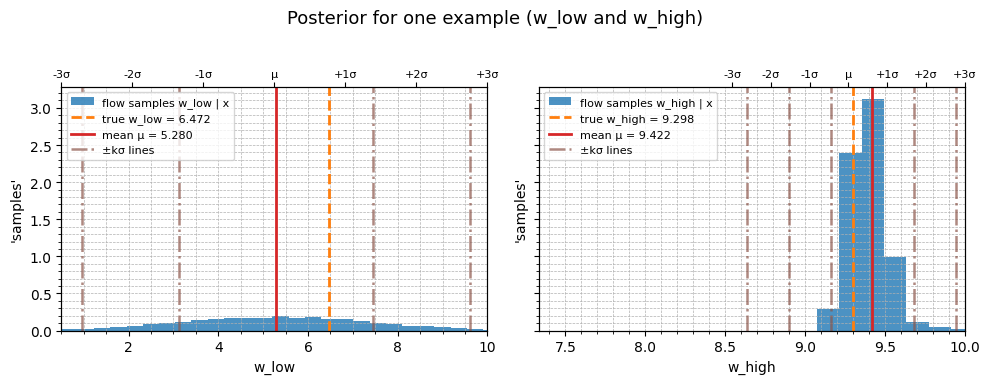

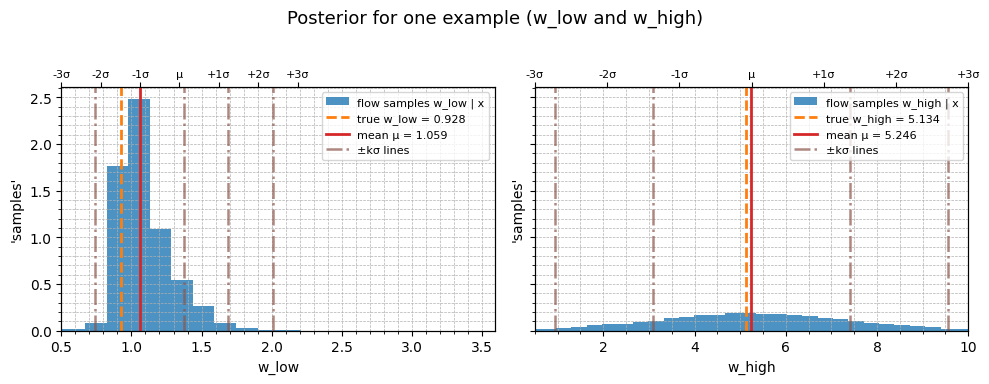

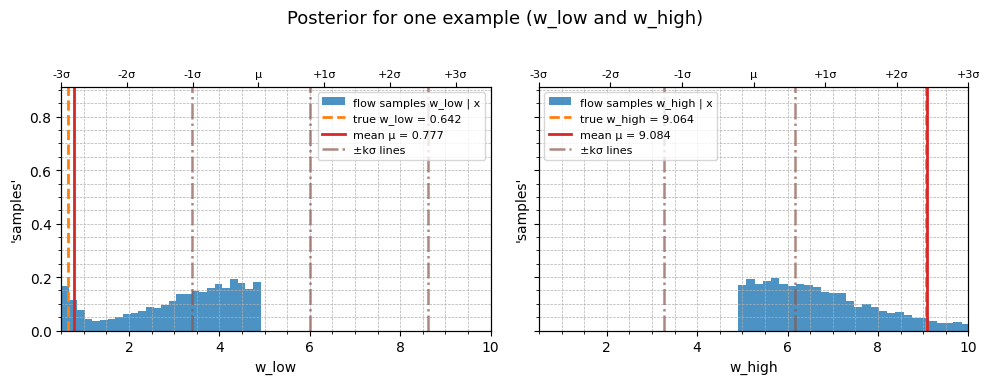

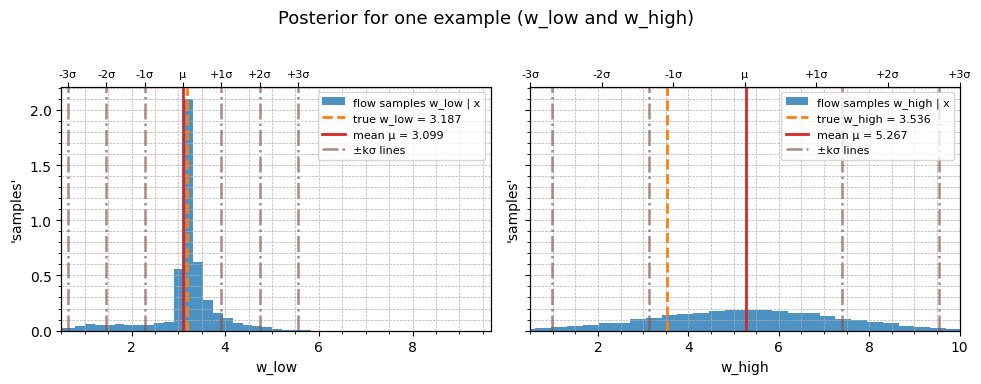

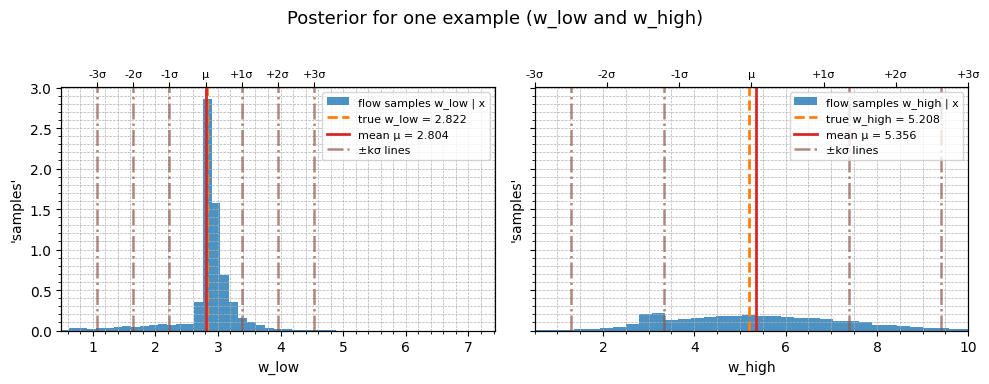

In [24]:
for idx in range(0, 5, 1):
    plot_flow_posterior_twofreq_one_example(
        model, device, test_loader,
        global_index=idx,
        num_samples=10000,
        bins=50,
        show_plot=True,
    )

In [9]:
@torch.no_grad()
def prediction_collecter_plot_double_raw(loader, model, device):
    """Collect raw (unsorted) predictions and targets for 2-freq model."""

    model.eval()
    y_true_list, y_pred_list = [], []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)                  # (B, 2)

        y_true_list.append(yb.cpu())
        y_pred_list.append(pred.cpu())

    y_true = torch.cat(y_true_list, dim=0)
    y_pred = torch.cat(y_pred_list, dim=0)
    return y_true, y_pred


In [16]:
def plot_pred_vs_true_double_sorted(
    y_true,
    y_pred,
    test_mse,
    test_mae,
    N: int = cfg.num_of_samples,
    t_disc: int = cfg.discr_of_time,
    w_min: float = cfg.omega_min,
    w_max: float = cfg.omega_max,
    seed=cfg.seed,
    sigma: float = cfg.noise_std,
    folder=cfg.plots_dir,
    save_plot: bool = False,
    show_plot: bool = False,
):
    """
    Visual diagnostics for double-frequency model.

    For each sample we sort true and predicted omegas by value:
        w_low  = min(w1, w2)
        w_high = max(w1, w2)

    Then we plot:
      (1) true w_low  vs predicted w_low
      (2) true w_high vs predicted w_high
      (3) true (w_low,  w_high)  frequency space
      (4) pred (w_low,  w_high)  frequency space
    """

    # --- to numpy ---
    if hasattr(y_true, "detach"):  # torch tensor
        y_true_np = y_true.detach().cpu().numpy()
        y_pred_np = y_pred.detach().cpu().numpy()
    else:
        y_true_np = np.asarray(y_true)
        y_pred_np = np.asarray(y_pred)

    # sort each pair by value, not by error
    y_true_np = np.sort(y_true_np, axis=1)  # (N, 2)
    y_pred_np = np.sort(y_pred_np, axis=1)  # (N, 2)

    w1_true = y_true_np[:, 0]  # w_low
    w2_true = y_true_np[:, 1]  # w_high
    w1_pred = y_pred_np[:, 0]
    w2_pred = y_pred_np[:, 1]

    # component-wise MAE (low / high)
    mae_w1 = np.mean(np.abs(w1_pred - w1_true))
    mae_w2 = np.mean(np.abs(w2_pred - w2_true))

    # limits for diagonal
    mn = min(y_true_np.min(), y_pred_np.min())
    mx = max(y_true_np.max(), y_pred_np.max())

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    ax11, ax12, ax21, ax22 = axes.ravel()

    # (1) w_low: true vs pred
    ax11.scatter(w1_true, w1_pred, s=14, alpha=0.6)
    ax11.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1)
    ax11.set_xlabel("True w_low")
    ax11.set_ylabel("Predicted w_low")
    ax11.set_title(f"w_low – MAE={mae_w1:.4f}")
    ax11.grid(True, which="both")

    # (2) w_high: true vs pred
    ax12.scatter(w2_true, w2_pred, s=14, alpha=0.6)
    ax12.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1)
    ax12.set_xlabel("True w_high")
    ax12.set_ylabel("Predicted w_high")
    ax12.set_title(f"w_high – MAE={mae_w2:.4f}")
    ax12.grid(True, which="both")

    # (3) true frequency space
    ax21.scatter(w1_true, w2_true, s=14, alpha=0.6)
    ax21.set_xlabel("w_low (true)")
    ax21.set_ylabel("w_high (true)")
    ax21.set_title("True frequency space")
    ax21.grid(True, which="both")
    ax21.set_xlim(w_min, w_max)
    ax21.set_ylim(w_min, w_max)

    # (4) predicted frequency space
    ax22.scatter(w1_pred, w2_pred, s=14, alpha=0.6, color="tab:orange")
    ax22.set_xlabel("w_low (pred)")
    ax22.set_ylabel("w_high (pred)")
    ax22.set_title("Predicted frequency space")
    ax22.grid(True, which="both")
    ax22.set_xlim(w_min, w_max)
    ax22.set_ylim(w_min, w_max)

    fig.suptitle(
        f"Double-sine – Test N={N}, w=[{w_min}-{w_max}], tdis={t_disc}\n"
        f"Overall MSE={test_mse:.6f}, MAE={test_mae:.6f}, std={sigma}",
        fontsize=11,
    )
    fig.tight_layout()

    if save_plot:
        fig.savefig(
            folder
            / f"T3_double_sorted_N{N}_tdis{t_disc}_w{w_min}-{w_max}_seed{seed}_std{sigma}_PREDvsREAL.png",
            dpi=300,
        )

    if show_plot:
        plt.show()

    plt.close(fig)


In [17]:
y_true, y_pred = prediction_collecter_plot_double_raw(test_loader, model, device)

plot_pred_vs_true_double_sorted(
    y_true,
    y_pred,
    test_mse=test_mse,
    test_mae=test_mae,
    save_plot=True,
    show_plot=True,
)

NameError: name 'prediction_collecter_plot_double_raw' is not defined

In [12]:
def plot_pred_vs_true_double_sorted(
    y_true,
    y_pred,
    test_mse,
    test_mae,
    N: int = cfg.num_of_samples,
    t_disc: int = cfg.discr_of_time,
    w_min: float = cfg.omega_min,
    w_max: float = cfg.omega_max,
    seed=cfg.seed,
    sigma: float = cfg.noise_std,
    folder=cfg.plots_dir,
    save_plot: bool = False,
    show_plot: bool = False,
):
    """
    Visual diagnostics for double-frequency model, using sorted pairs.

    For each sample we sort true and predicted omegas by value:
        w_low  = min(w1, w2)
        w_high = max(w1, w2)

    Then we plot:
      (1) true w_low  vs predicted w_low
      (2) true w_high vs predicted w_high
    """

    # --- to numpy ---
    if hasattr(y_true, "detach"):  # torch tensor
        y_true_np = y_true.detach().cpu().numpy()
        y_pred_np = y_pred.detach().cpu().numpy()
    else:
        y_true_np = np.asarray(y_true)
        y_pred_np = np.asarray(y_pred)

    # sort each pair by value, not by error
    y_true_np = np.sort(y_true_np, axis=1)  # (N, 2)
    y_pred_np = np.sort(y_pred_np, axis=1)  # (N, 2)

    w1_true = y_true_np[:, 0]  # w_low
    w2_true = y_true_np[:, 1]  # w_high
    w1_pred = y_pred_np[:, 0]
    w2_pred = y_pred_np[:, 1]

    mae_w1 = np.mean(np.abs(w1_pred - w1_true))
    mae_w2 = np.mean(np.abs(w2_pred - w2_true))

    mn = min(y_true_np.min(), y_pred_np.min())
    mx = max(y_true_np.max(), y_pred_np.max())

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ax1, ax2 = axes

    # small internal helper so both panels look the same
    def _scatter_panel(ax, x_true, y_pred, label, mae):
        ax.scatter(x_true, y_pred, s=14, alpha=0.6)
        ax.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1)
        ax.set_xlabel(f"True {label}")
        ax.set_ylabel(f"Predicted {label}")
        ax.set_title(f"{label} – MAE={mae:.4f}")
        ax.grid(True, which="both")

    _scatter_panel(ax1, w1_true, w1_pred, "w_low", mae_w1)
    _scatter_panel(ax2, w2_true, w2_pred, "w_high", mae_w2)

    fig.suptitle(
        f"Double-sine – Test N={N}, w=[{w_min}-{w_max}], tdis={t_disc}\n"
        f"Overall MSE={test_mse:.6f}, MAE={test_mae:.6f}, std={sigma}",
        fontsize=11,
    )
    fig.tight_layout()

    if save_plot:
        fig.savefig(
            folder
            / f"T3_double_sorted_N{N}_tdis{t_disc}_w{w_min}-{w_max}_seed{seed}_std{sigma}_PREDvsREAL.png",
            dpi=300,
        )

    if show_plot:
        plt.show()

    plt.close(fig)


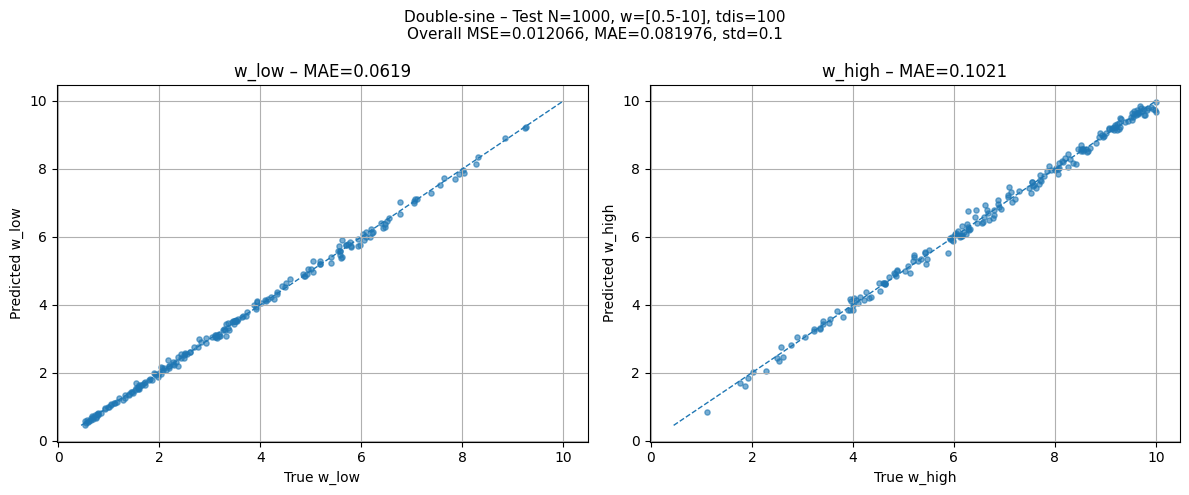

In [13]:
plot_pred_vs_true_double_sorted(
    y_true,
    y_pred,
    test_mse=test_mse,
    test_mae=test_mae,
    save_plot=True,
    show_plot=True,
)